### Init

In [ ]:
%%capture

!pip install datasets transformers pandas matplotlib tqdm --upgrade --quiet


In [ ]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

C:\Users\Alvin\anaconda3\envs\analysis_1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the dataset

We just want the dataset test split here for evaluation

In [ ]:
split_name = "test"

dataset_name, dataset_config_name = "go_emotions", "simplified"
dataset_dict = datasets.load_dataset(dataset_name, dataset_config_name)
dataset_dict[split_name][0]

{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
 'labels': [25],
 'id': 'eecwqtt'}

In [ ]:
labels = dataset_dict[split_name].features["labels"].feature.names
print({i: l for i, l in enumerate(labels)})

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


Load into a `y_target` stucture of arrays by label (since we wish to evaluate per label for a multi-label, multi-class dataset like this)

In [ ]:
num_items, num_labels = len(dataset_dict[split_name]), len(labels)
y_targets_all = np.zeros((num_items, num_labels), dtype=int)
for i, labels_indices in enumerate(dataset_dict[split_name]["labels"]):
    for label_index in labels_indices:
        y_targets_all[i, label_index] = 1

print(y_targets_all[0:3])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Load the model and run it

Loading in a multi-label, multi-class classifier model based on Roberta-base

In [ ]:
# classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import pandas as pd
from datasets import Dataset
import torch
import argparse
import time
import os
from transformers import  AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
import torch.cuda.amp as amp
import tqdm
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--pretrained_model_name',required=False, type=str, default='xlnet-base-cased', help='Name of the pre-trained BERT model')
# parser.add_argument('--dataset', type=str,required=False, default='emotion', help='Name of dataset')
# parser.add_argument('--epoch', type=int,required=False, default=5, help='Number of training epoches')
# parser.add_argument('--lr', type=int,required=False, default=2e-5, help='Learning Rate')
# parser.add_argument('--batch_size', type=int,required=False, default=16, help='Batch size for training and testing')
# parser.add_argument('--maxlengthToPass', type=int,required=False, default=32, help='max length used by tokenizer')
# parser.add_argument("-f", required=False)
# args = parser.parse_args()

In [ ]:
# args = {
#   'pretrained_model_name': 'albert-base-v2',
#   'dataset': 'emotion',
#   'epoch': 5,
#   'lr': 2e-5,
#   'batch_size': 16,
#   'maxlengthToPass': 32
# }
argspretrained_model_name = 'xlnet-base-cased'
argsdataset = 'emotion'
argsepoch = 5
argslr = 2e-5
argsbatch_size = 16
argsmaxlengthToPass = 32

In [ ]:
# Parameters
argspretrained_model_name = "xlnet-base-cased"
argsmaxlengthToPass = 16
argslr = 2e-05
argsbatch_size = 16


In [ ]:
def custom_dataloader(datasets, tokenizer_name, batch_size):
    data = pd.read_csv(f'./data/{datasets}.tsv', sep='\t', names = ['text', 'labels', 'origin'])
    # data['labels'].astype(int)
    # print(data['labels'].dtype)
    def multi_label(x):
        return [1.0 if i in [int(label) for label in x.split(',')] else 0 for i in range(28)]
    data['labels'] = data.apply(lambda x: multi_label(x['labels']), axis=1)
    # print(data)
    data = data.drop('origin',axis=1)
    datasets = Dataset.from_pandas(data)
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name,model_max_length=argsmaxlengthToPass)
    # ,model_max_length=16
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True)
    tokenized_datasets = datasets.map(tokenize_function, batched=True)
    tokenized_datasets.set_format("torch",columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

    dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=batch_size)

    return dataloader

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    sigmoid = torch.nn.Sigmoid()
    # softmax = torch.nn.Softmax(dim=1)
    probs = sigmoid(torch.Tensor(predictions)).detach().cpu().numpy()
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels.detach().cpu().numpy()
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # precision = precision_score(y_true, y_pred)
    # recall = recall_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    total_precision = 0
    total_recall = 0
    num_total = 0
    total_f1 = 0
    num_acc = 0
    with torch.no_grad():
        for batch in test_loader:
            labels = batch['labels'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            output = model(input_ids, attention_mask).logits
            loss = torch.nn.BCEWithLogitsLoss()(output, labels)
            total_loss += loss.item()
            temp = multi_label_metrics(output, labels)
            temp_acc = temp['accuracy']
            total_correct += temp['accuracy']
            # print(f'\tTest Accuracy: {temp_acc:.5f}')
            # total_precision += temp['precision']
            # total_recall += temp['recall']
            total_f1 += temp['f1']
            total_samples += labels.size(0)
            num_total += labels.size(0)
            num_acc +=1
    average_loss = total_loss / num_total
    accuracy = (total_correct / num_acc) * 100.0
    avg_f1 = (total_f1 / num_acc)
    # precision = total_precision / num_acc
    # recall = total_recall / num_acc
    # F1 = (2*precision*recall)/(precision+recall)
    print(f'\tTest F1: {avg_f1:.5f}')
    return average_loss, accuracy

In [ ]:
def train(model, train_loader, optimizer, scheduler):
    model.train()
    total_loss = 0
    num_correct = 0
    num_total = 0
    total_acc = 0.0
    num_acc = 0
    # Start Training by batch size
    for i, batch in enumerate(train_loader):
        labels = batch['labels'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask).logits
        loss = torch.nn.BCEWithLogitsLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        # metrics = multi_label_metrics(outputs, labels)
        curr_loss = loss.item()
        total_loss += loss.item()
        num_total += labels.size(0)
        metrics = multi_label_metrics(outputs, labels)
        total_acc = metrics['accuracy'] + total_acc
        num_acc +=1
#         if i % 10 == 9:
#             print('  batch {} loss: {}'.format(i + 1, curr_loss/10))
#             print(metrics['accuracy'])
    avg_train_loss = total_loss / num_total
    avg_train_acc = total_acc / num_acc
    return avg_train_loss, avg_train_acc*100

In [ ]:
best_acc = 0

train_loader = custom_dataloader('train', argspretrained_model_name, argsbatch_size)
valid_loader = custom_dataloader('dev', argspretrained_model_name, argsbatch_size)
test_loader = custom_dataloader('test', argspretrained_model_name, argsbatch_size)

model = AutoModelForSequenceClassification.from_pretrained(argspretrained_model_name, problem_type="multi_label_classification", num_labels=28)
model.to(device)

optimizer = AdamW(model.parameters(), lr=argslr, weight_decay=0.0001)
num_epochs = argsepoch
num_training_steps = num_epochs * len(train_loader)
scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps)

for epoch in range(argsepoch):
    print("Epoch: ", (epoch+1))
    start_time = time.time()
    avg_train_loss, avg_train_acc = train(model, train_loader, optimizer, scheduler)
#     avg_valid_loss = valid(model, train_loader, optimizer, scheduler)

    end_time = time.time()
    avg_test_loss, avg_test_acc = evaluate(model, valid_loader)
    epoch_time = end_time - start_time
    print(f'\tTrain Loss: {avg_train_loss:.5f} | Train Acc: {avg_train_acc:.4f}%')
    # print(f'\tValid Loss: {avg_valid_loss:.5f}')

    print(f'\tTest. Loss: {avg_test_loss:.5f} |  Test Acc: {avg_test_acc:.4f}%')
    print(f"\tTime: {epoch_time:.2f} seconds")
    # if avg_test_acc > best_acc:
    #     best_acc = avg_test_acc
    #     torch.save(model, "./" + args.dataset + ".pt")

Map: 100%|███████████████████████████████████████████████████████████████| 5427/5427 [00:00<00:00, 40399.78 examples/s]
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch:  1
	Test F1: 0.35236
	Train Loss: 0.01063 | Train Acc: 9.1240%
	Test. Loss: 0.00699 |  Test Acc: 23.3640%
	Time: 140.50 seconds
Epoch:  2
	Test F1: 0.49211
	Train Loss: 0.00667 | Train Acc: 31.9247%
	Test. Loss: 0.00631 |  Test Acc: 37.3713%
	Time: 123.99 seconds
Epoch:  3
	Test F1: 0.49943
	Train Loss: 0.00598 | Train Acc: 39.1396%
	Test. Loss: 0.00621 |  Test Acc: 37.9412%
	Time: 121.51 seconds
Epoch:  4
	Test F1: 0.50438
	Train Loss: 0.00545 | Train Acc: 44.4938%
	Test. Loss: 0.00625 |  Test Acc: 38.5662%
	Time: 122.25 seconds
Epoch:  5
	Test F1: 0.51041
	Train Loss: 0.00504 | Train Acc: 48.6321%
	Test. Loss: 0.00631 |  Test Acc: 39.5956%
	Time: 121.32 seconds


In [ ]:
# torch.save(model, "./" + args.pretrained_model_name + "_" + str(args.epoch) + "_" + str(args.lr) + "_" + str(args.batch_size) + ".pt")

In [ ]:
# model = torch.load("albert-base-v2_6_2e-05_16_max_length=64.pt")
# model.eval()

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

In [ ]:
import torch.nn.functional as F

y_probas_all = np.empty
y_preds_all = np.empty
y_labels_all = np.empty
bool_temp = False
test_loader = custom_dataloader('test', argspretrained_model_name, 20)
model.eval()
for batch in test_loader:
    labels = batch['labels'].to(device)
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    output = model(input_ids,attention_mask).logits

    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(output)).detach().cpu().numpy()
    y_true = labels.detach().cpu().numpy()
    if(bool_temp == False):
        y_probas_all = probs
        y_labels_all = y_true

        bool_temp = True
    else:
        y_probas_all = np.concatenate((y_probas_all, probs), axis=0)
        y_labels_all = np.concatenate((y_labels_all, y_true), axis=0)



Map: 100%|███████████████████████████████████████████████████████████████| 5427/5427 [00:00<00:00, 36185.27 examples/s]


In [ ]:
dataset_dict = datasets.load_dataset(dataset_name, dataset_config_name)
labels = dataset_dict[split_name].features["labels"].feature.names
y_targets_all = y_labels_all

### Evalutation

In [ ]:
from sklearn import metrics

We first see the metrics at a threshold of 0.5

In [ ]:
threshold = 0.5
y_preds_all = np.zeros(y_probas_all.shape)
y_preds_all[np.where(y_probas_all >= threshold)] = 1

print("Overall (macro)")
print("===============")
print(f"Accuracy: {metrics.accuracy_score(y_targets_all, y_preds_all):.3f}")
print(f"Precision: {metrics.precision_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"Recall: {metrics.recall_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"F1: {metrics.f1_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")

Overall (macro)
Accuracy: 0.388
Precision: 0.514
Recall: 0.332
F1: 0.387


In [ ]:
def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "accuracy": metrics.accuracy_score(y_targets, y_preds),
        "precision": metrics.precision_score(y_targets, y_preds, zero_division=0),
        "recall": metrics.recall_score(y_targets, y_preds, zero_division=0),
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "mcc": metrics.matthews_corrcoef(y_targets, y_preds),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

In [ ]:
threshold = 0.5
y_preds_all = np.zeros(y_probas_all.shape)
y_preds_all[np.where(y_probas_all >= threshold)] = 1

results = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
    results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

per_label_results = pd.DataFrame(results, index=labels)
display(per_label_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.934,0.655,0.619,0.637,0.601,504.0,0.5
amusement,0.973,0.786,0.614,0.689,0.681,264.0,0.5
anger,0.963,0.484,0.308,0.377,0.368,198.0,0.5
annoyance,0.940,0.480,0.112,0.182,0.212,320.0,0.5
approval,0.930,0.441,0.288,0.348,0.321,351.0,0.5
caring,0.974,0.476,0.289,0.359,0.358,135.0,0.5
confusion,0.970,0.447,0.248,0.319,0.319,153.0,0.5
curiosity,0.945,0.475,0.475,0.475,0.446,284.0,0.5
desire,0.986,0.592,0.349,0.439,0.448,83.0,0.5
disappointment,0.972,0.478,0.073,0.126,0.179,151.0,0.5


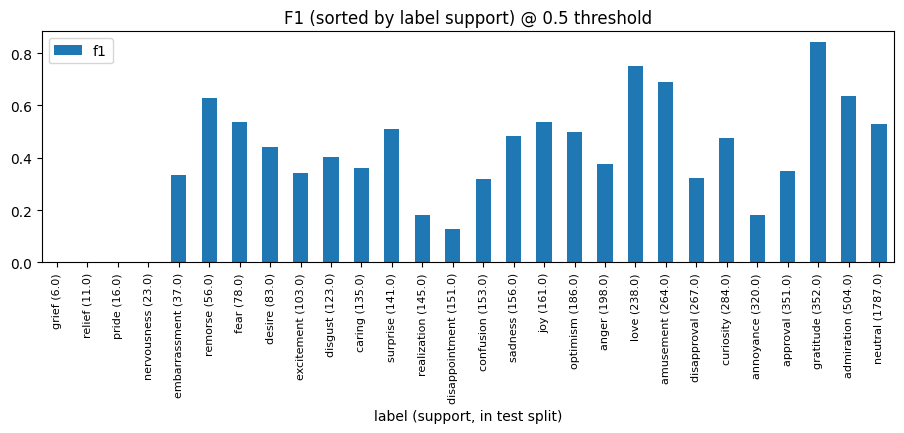

In [ ]:
per_label_results["label (support)"] = (
    per_label_results.index + " (" + per_label_results["support"].astype(str) + ")"
)
ax = per_label_results.sort_values(by="support").plot.bar(
    x="label (support)",
    y=["f1"],
    rot=90,
    title="F1 (sorted by label support) @ 0.5 threshold",
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

Now we create dataset-wide metrics from per-label metrics

In [ ]:
def dataset_wide_metrics(df):
    simple_mean = {
        m: round(df[m].mean(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Simple mean of labels:", simple_mean)
    weighted = {
        m: round(sum(df[m] * df["support"]) / df["support"].sum(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Weighted average (using support):", weighted)
    return simple_mean, weighted

_ = dataset_wide_metrics(per_label_results)

Simple mean of labels: {'precision': 0.514, 'recall': 0.332, 'f1': 0.387, 'mcc': 0.386}
Weighted average (using support): {'precision': 0.619, 'recall': 0.417, 'f1': 0.486, 'mcc': 0.443}


Now we explore how the metrics vary by threshold, rather than naively setting it at 0.5 as above

In [ ]:
from tqdm import tqdm

threshold_results = {}
for t in tqdm(range(5, 100, 5)):
    threshold = t / 100
    y_preds_all = (y_probas_all > threshold).astype(int)
    threshold_results[threshold] = []
    for label_index, label in enumerate(labels):
        y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
        threshold_results[threshold].append(calc_label_metrics(label, y_targets, y_preds, threshold))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  7.57it/s]


In [ ]:
metric_name = "f1"
best = {label: {metric_name: -1, "result": None} for label in labels}
for threshold, results in threshold_results.items():
    for result in results:
        label = result["label"]
        if result[metric_name] > best[label][metric_name]:
            best[label] = {metric_name: result[metric_name], "result": result}

results = [b["result"] for b in best.values()]
per_label_threshold_results = pd.DataFrame(results, index=[result["label"] for result in results])
display(per_label_threshold_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.933,0.640,0.639,0.640,0.603,504.0,0.45
amusement,0.973,0.778,0.625,0.693,0.684,264.0,0.45
anger,0.956,0.404,0.455,0.428,0.405,198.0,0.25
annoyance,0.915,0.307,0.347,0.326,0.281,320.0,0.25
approval,0.912,0.352,0.419,0.382,0.337,351.0,0.30
caring,0.964,0.339,0.452,0.387,0.373,135.0,0.25
confusion,0.964,0.367,0.379,0.373,0.355,153.0,0.30
curiosity,0.938,0.443,0.718,0.548,0.535,284.0,0.25
desire,0.985,0.513,0.470,0.491,0.483,83.0,0.20
disappointment,0.948,0.211,0.311,0.251,0.230,151.0,0.15


Charting it

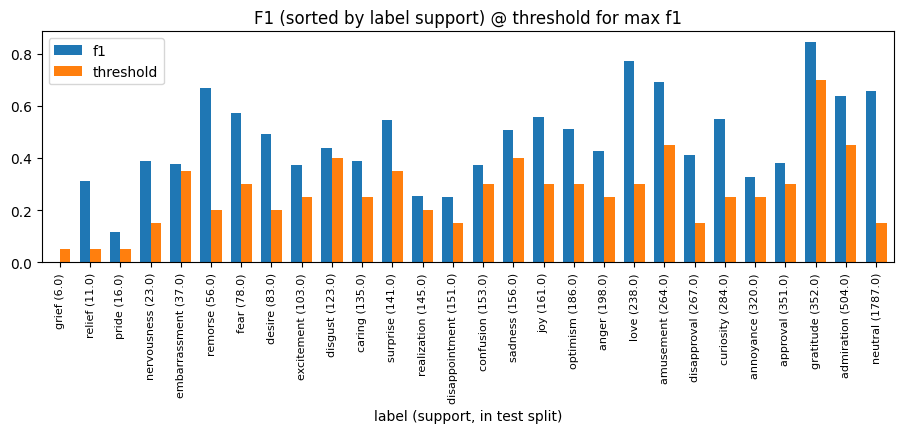

In [ ]:
per_label_threshold_results["label (support)"] = (
    per_label_threshold_results["label"] + " (" + per_label_threshold_results["support"].astype(str) + ")"
)
ax = per_label_threshold_results.sort_values(by="support").plot.bar(
    x='label (support)',
    y=["f1", "threshold"],
    rot=90,
    title="F1 (sorted by label support) @ threshold for max f1",
    width=0.7,
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

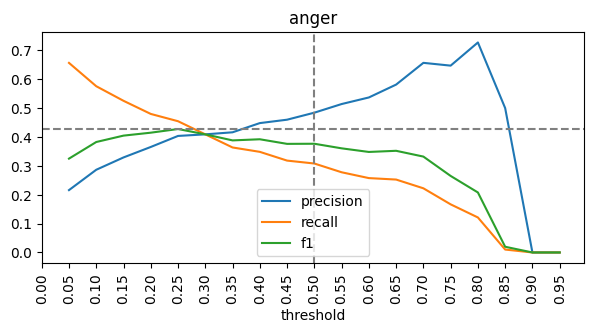

In [ ]:
_label_name = "anger"
label_per_threshold_results = []
for threshold, results in threshold_results.items():
    for result in results:
        if result["label"] == _label_name:
            label_per_threshold_results.append(result)

label_per_threshold_results = pd.DataFrame(
    label_per_threshold_results, index=[r["threshold"] for r in label_per_threshold_results]
)
ax = label_per_threshold_results.plot.line(
    x="threshold", y=["precision", "recall", "f1"], rot=90, title=_label_name, figsize=(7,3)
)
ax.axvline(0.5, color='gray', linestyle='--')
ax.axhline(label_per_threshold_results["f1"].max(), color="gray", linestyle="--")
ax.xaxis.set_ticks(np.arange(0, 1, 0.05))

plt.show()

In [ ]:
print("### Threshold set to arbitary 0.5")
_before = dataset_wide_metrics(per_label_results)
print()
print("### Threshold from per label search (for best F1 score)")
_after = dataset_wide_metrics(per_label_threshold_results)

print()
percentage = (_after[0]["f1"] - _before[0]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (simple mean) improved by {round(percentage, 1)}%")
percentage = (_after[1]["f1"] - _before[1]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (weighted) improved by {round(percentage, 1)}%")

### Threshold set to arbitary 0.5
Simple mean of labels: {'precision': 0.514, 'recall': 0.332, 'f1': 0.387, 'mcc': 0.386}
Weighted average (using support): {'precision': 0.619, 'recall': 0.417, 'f1': 0.486, 'mcc': 0.443}

### Threshold from per label search (for best F1 score)
Simple mean of labels: {'precision': 0.494, 'recall': 0.478, 'f1': 0.458, 'mcc': 0.446}
Weighted average (using support): {'precision': 0.532, 'recall': 0.606, 'f1': 0.555, 'mcc': 0.486}

F1 (simple mean) improved by 18.3%
F1 (weighted) improved by 17.8%
